# Import Required libraries

In [349]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras import models,layers,optimizers,utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Data Preparation

In [350]:
frame=pd.read_csv('sonar.csv',header=None)
frame.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [351]:
df = frame.sample(frac=1)
df.head()


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
178,0.0197,0.0394,0.0384,0.0076,0.0251,0.0629,0.0747,0.0578,0.1357,0.1695,...,0.0134,0.0097,0.0042,0.0058,0.0072,0.0041,0.0045,0.0047,0.0054,M
143,0.0516,0.0944,0.0622,0.0415,0.0995,0.2431,0.1777,0.2018,0.2611,0.1294,...,0.0432,0.0274,0.0152,0.0120,0.0129,0.0020,0.0109,0.0074,0.0078,M
151,0.0231,0.0315,0.0170,0.0226,0.0410,0.0116,0.0223,0.0805,0.2365,0.2461,...,0.0125,0.0036,0.0123,0.0043,0.0114,0.0052,0.0091,0.0008,0.0092,M
23,0.0115,0.0150,0.0136,0.0076,0.0211,0.1058,0.1023,0.0440,0.0931,0.0734,...,0.0091,0.0016,0.0084,0.0064,0.0026,0.0029,0.0037,0.0070,0.0041,R
48,0.0190,0.0038,0.0642,0.0452,0.0333,0.0690,0.0901,0.1454,0.0740,0.0349,...,0.0093,0.0118,0.0112,0.0094,0.0140,0.0072,0.0022,0.0055,0.0122,R


In [352]:
sonar=df.values
data = sonar[:,0:60].astype('float')
labels = sonar[:,60]
from sklearn.preprocessing import LabelEncoder
# encode class values as integers
le = LabelEncoder()
encoded_Y = le.fit_transform(labels)
encoded_Y.ndim

1

In [353]:
x_train = sonar[:167,:60].astype('float')
train_labels = encoded_Y[:167]
y_test = sonar[167:,:60].astype('float')
test_labels = encoded_Y[167:]
print(train_labels.ndim)

1


In [354]:
print(x_train.shape)
print(train_labels.shape)
print(y_test.shape)
print(test_labels.shape)

(167, 60)
(167,)
(41, 60)
(41,)


# Step 3:Slicing for Validation

In [355]:
x_val=x_train[:21] 
partial_x_train=x_train[21:] 
val_label=train_labels[:21]
partial_train_label=train_labels[21:]

In [356]:
print(x_val.shape)
print(val_label.ndim)
print(partial_x_train.shape)
partial_x_train.shape[1]

(21, 60)
1
(146, 60)


60

# Step 4:Building Model Network

In [332]:
def build_model():
    model=models.Sequential()
    model.add(layers.Dense(40,activation='relu',input_dim=60))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# K-FOLD

In [342]:
k=10
num_val_samples=len(partial_x_train)//k
num_epochs=50
all_scores=[]
all_mae_histories=[]
for i in range(k):
    print("proccessing fold #",i)
    val_data=partial_x_train[i*num_val_samples:(i+1)*num_val_samples]
    val_labels=partial_train_label[i*num_val_samples:(i+1)*num_val_samples]
    partial_train_data=np.concatenate([partial_x_train[:i*num_val_samples],partial_x_train[(i+1)*num_val_samples:]],axis=0)
    partial_train_labels=np.concatenate([partial_train_label[:i*num_val_samples],partial_train_label[(i+1)*num_val_samples:]],axis=0)
    model=build_model()
    history=model.fit(partial_train_data, partial_train_labels,
                      epochs=num_epochs, batch_size=30, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_labels, verbose=0)
    all_scores.append(val_mae)
    mae_history = history.history['accuracy']
    all_mae_histories.append(mae_history)

proccessing fold # 0
proccessing fold # 1
proccessing fold # 2
proccessing fold # 3
proccessing fold # 4
proccessing fold # 5
proccessing fold # 6
proccessing fold # 7
proccessing fold # 8
proccessing fold # 9


In [343]:
avg_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
print('all fold validation error',all_scores)
print('Mean of all fold validation error',np.mean(all_scores))
print('Average mae history',avg_mae_history)

all fold validation error [0.64285713, 0.71428573, 0.5, 0.85714287, 0.9285714, 0.85714287, 0.71428573, 0.78571427, 0.85714287, 0.85714287]
Mean of all fold validation error 0.7714286
Average mae history [0.50909096, 0.55, 0.5772727, 0.5909091, 0.6015152, 0.6128788, 0.6242424, 0.655303, 0.67954546, 0.69469696, 0.7037879, 0.7174242, 0.7401515, 0.7530303, 0.7643939, 0.7810606, 0.78333336, 0.7939394, 0.8098485, 0.8090909, 0.8098485, 0.8287879, 0.8295455, 0.8356061, 0.8469698, 0.8416667, 0.8530303, 0.8462121, 0.8515152, 0.8545455, 0.8598485, 0.8636364, 0.8643939, 0.8659091, 0.8666667, 0.8727273, 0.8681818, 0.880303, 0.8742424, 0.885606, 0.8878787, 0.8840909, 0.8848484, 0.8878788, 0.8871212, 0.8931818, 0.8939393, 0.8984848, 0.9022727, 0.9037878]


In [344]:
[len(x) for x in all_mae_histories]

[50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

In [345]:
history=model.fit(partial_x_train,partial_train_label,epochs=30,batch_size=10,validation_data=(x_val,val_label))

Train on 146 samples, validate on 21 samples
Epoch 1/30
146/146 [==============================] - 1s 4ms/sample - loss: 0.6844 - accuracy: 0.5548 - val_loss: 0.7131 - val_accuracy: 0.4286
Epoch 2/30
146/146 [==============================] - 0s 274us/sample - loss: 0.6593 - accuracy: 0.5616 - val_loss: 0.6744 - val_accuracy: 0.4286
Epoch 3/30
146/146 [==============================] - 0s 274us/sample - loss: 0.6376 - accuracy: 0.5890 - val_loss: 0.6619 - val_accuracy: 0.3810
Epoch 4/30
146/146 [==============================] - 0s 247us/sample - loss: 0.6257 - accuracy: 0.5890 - val_loss: 0.6305 - val_accuracy: 0.6190
Epoch 5/30
146/146 [==============================] - 0s 247us/sample - loss: 0.6063 - accuracy: 0.7055 - val_loss: 0.6034 - val_accuracy: 0.7143
Epoch 6/30
146/146 [==============================] - 0s 247us/sample - loss: 0.5908 - accuracy: 0.7260 - val_loss: 0.5932 - val_accuracy: 0.7143
Epoch 7/30
146/146 [==============================] - 0s 246us/sample - loss: 0.5

In [346]:

test_mse_score, test_mae_score = model.evaluate(y_test,test_labels)

41/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [347]:
history_dict=history.history

# Plot Graph

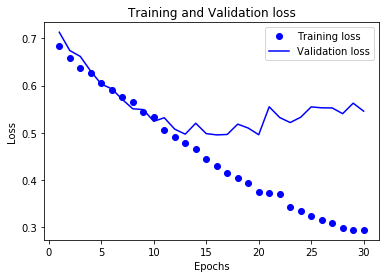

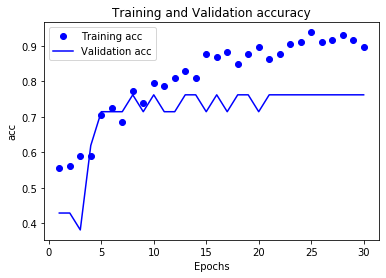

<function matplotlib.pyplot.clf()>

In [348]:

loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)
plt.plot(epochs,loss_values,'bo',label='Training loss')
plt.plot(epochs,val_loss_values,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf
acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,len(acc_values)+1)
plt.plot(epochs,acc_values,'bo',label='Training acc')
plt.plot(epochs,val_acc_values,'b',label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()
plt.clf